In [1]:
import pyleoclim as pyleo
import json
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from scipy.signal import find_peaks,peak_widths,peak_prominences
from statistics import mean
from scipy.optimize import linear_sum_assignment
import itertools

In [2]:
freqs=[1/20,1/80]
time=np.arange(2001)
signals=[]
for freq in freqs:
    signals.append(np.cos(2*np.pi*freq*time))
signal=sum(signals)
slope = 1e-5
intercept = -1
nonlinear_trend = slope*time**2 + intercept
signal_trend = signal + nonlinear_trend
sig_var = np.var(signal)
noise_var = sig_var / 2 #signal is twice the size of noise
white_noise = np.random.normal(0, np.sqrt(noise_var), size=np.size(signal))
signal_noise = signal_trend + white_noise
gap_length = 100


In [3]:
plt.plot(time,signal_noise)

In [4]:
nt= np.size(time)

In [5]:
 deleted_idx = np.arange(nt//2-gap_length//2, nt//2+gap_length//2)

In [6]:
time_unevenly = np.delete(time,deleted_idx)
signal_unevenly = np.delete(signal_noise,deleted_idx)

In [7]:
len(time_unevenly)

1901

In [8]:
 plt.plot(time_unevenly,signal_unevenly)

In [9]:
ts = pyleo.Series(time_unevenly,signal_unevenly)

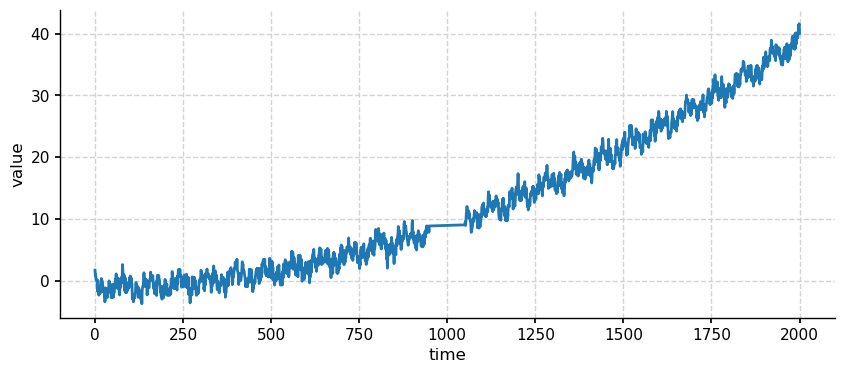

(<Figure size 1000x400 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc37aa46d60>)

In [10]:
ts.plot()

In [11]:
multiple_series = ts.segment()

In [12]:
def standardize(ts):
    ts_std = ts.standardize()
    return ts_std

In [13]:
def segment(ts):
    ts_segment = ts.segment()
    return ts_segment

In [14]:
def detrend(ts,method):
    ts_detrend = ts.detrend(method=method)
    return ts_detrend

In [15]:
def spectral(ts,method):
    psd =ts.spectral(method=method)
    return psd

In [16]:
def significance(psd):
    psd_signif = psd.signif_test(qs=[0.95])
    return psd_signif

In [17]:
ts_std = standardize(ts)

In [18]:
ts_segment = segment(ts_std)

In [19]:
ts_segment

In [20]:
def cost_function(res_psd,actual_freqs,signif_qs_psd_amplitude,dist_tol=0,peak_tol=0):
    #num_peaks= number of actual peaks in the frequency
    #tol = tolerance, if inaccuracy is less than tol, then return 0
    '''
    1. find all peaks
    2. calc cost function for num_peaks, find peaks closest to actual peak.
    3. 
    #rank by correct num peaks, distance, height/width ratio
    #try instead of adding distance, try normalized mean of distances
    '''
        
    correct_num_peaks=True
    peaks,h=find_peaks(res_psd['amplitude'],height=0)
    height_tol=peak_tol*mean(h['peak_heights'])

    prom,_,__=peak_prominences(res_psd['amplitude'],peaks)
    prom_thresh=mean(prom)*peak_tol
   
    peaks,props=find_peaks(res_psd['amplitude'],prominence=prom_thresh,height=height_tol)
    
   
    if len(peaks) < len(actual_freqs):
        correct_num_peaks=False       
    widths=np.array(peak_widths(res_psd['amplitude'],peaks,rel_height=0.99)[0])
    #only consider peaks clostest to actual freqs, need te do bipartite matching (using linear sum assignment func)
    #assignment problem between peaks and actual_freqs
    #create cost matrix, rows=peaks, cols= actual_freq, cost= dist
    temp_combs=np.array(list(itertools.product(res_psd['frequency'][peaks],actual_freqs)))
    #print(temp_combs)
    dist=lambda x,y:abs(x-y)
    optimum = []
    l = res_psd['frequency'][peaks]
   
    
    
            
    cost=dist(temp_combs[:,0],temp_combs[:,1]).reshape(-1,len(actual_freqs)) #rows = peak, 
    
    row_ind,col_ind=linear_sum_assignment(cost)
    
    dists=np.mean(cost[row_ind,col_ind],dtype=float)    
    peakidx=row_ind
    peak_amplitude = []
    detected_amplitude = []
    indexes = []
    #from the index finding the frequency closest to actual frequency of psd and then extracting the corresponding 
    # amplitude
   
    for idx in peakidx:
        
        indexes.append(np.where(res_psd['frequency']==l[idx])[0][0])
        x = np.where(res_psd['frequency']==l[idx])[0][0]
        peak_amplitude.append(res_psd['amplitude'][x])
    
    # extracting amplitude of 95% series at peak 
    for idx in indexes:
       
        detected_amplitude.append(signif_qs_psd_amplitude[idx])
    peak_heights=props['peak_heights'][peakidx]
    flag = True
    for i in range(len(peak_amplitude)):
        if peak_amplitude[i] < detected_amplitude[i]:
            flag = False
            break
   
   

    avg_height_width_ratio=mean([peak_height/widths[i] for i,peak_height in enumerate(peak_heights)])
    res = None
    if flag ==True and correct_num_peaks==True:
        res = 2
    elif flag==True and correct_num_peaks == False or flag==False and correct_num_peaks==True:
        res = 1
    else:
        res = 0

    #dist tol is an accuracy tolerance for distance of peak to actual freq
    if dists<dist_tol:
        dists=0
    return (correct_num_peaks,avg_height_width_ratio,res)

Performing spectral analysis on surrogates: 100%|██████████| 200/200 [00:07<00:00, 27.11it/s]


True 26.752076668187613 2


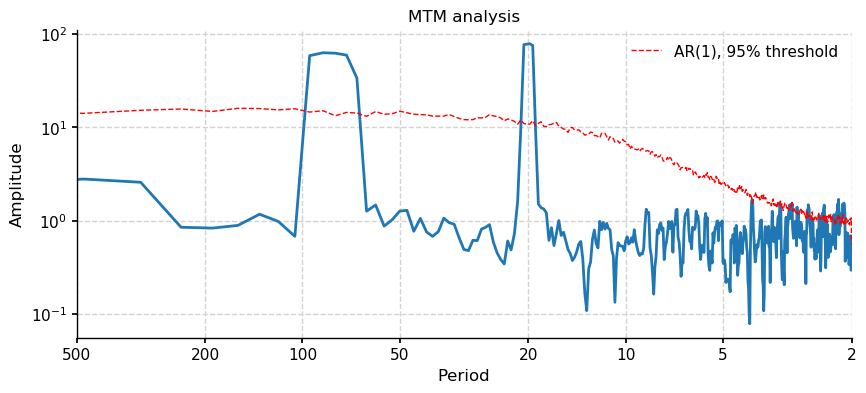

Performing spectral analysis on surrogates: 100%|██████████| 200/200 [00:07<00:00, 27.23it/s]


True 30.565954655332188 2


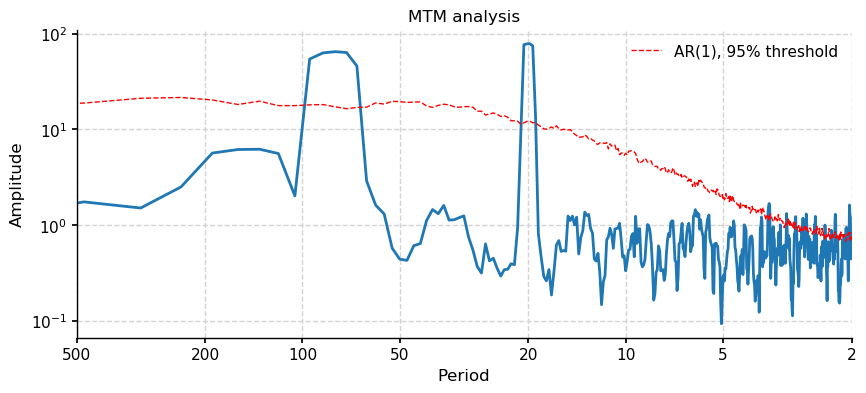

In [21]:
for ts in ts_segment.series_list:
    ts = detrend(ts,method='emd')
    psd_mtm = spectral(ts,method='mtm')
    psd_signif = significance(psd_mtm)
    amplitude= None
    for p in psd_signif.signif_qs.psd_list:
        amplitude = p.amplitude
    a,b,c = cost_function(psd_mtm.__dict__,[1/20,1/80],amplitude)
    print(a,b,c)
    fig, ax = psd_signif.plot(title='MTM analysis')

Performing spectral analysis on surrogates: 100%|██████████| 200/200 [37:00<00:00, 11.10s/it]


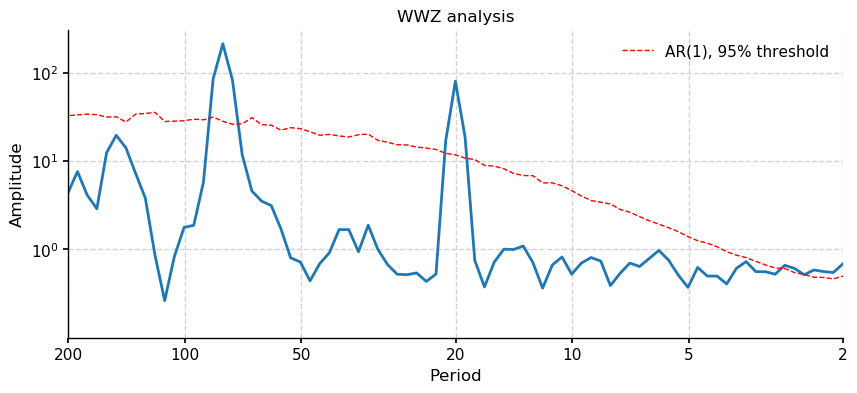

True 23.634184133141968 2


In [23]:
ts = detrend(ts,method='emd')
psd_mtm = spectral(ts,method='wwz')
psd_signif = significance(psd_mtm)
amplitude= None
for p in psd_signif.signif_qs.psd_list:
    amplitude = p.amplitude
a,b,c = cost_function(psd_mtm.__dict__,[1/20,1/80],amplitude)
fig, ax = psd_signif.plot(title='WWZ analysis')
print(a,b,c)

###### 